In [1]:
import pandas as pd

# Load dataset
file_path = r"D:\college\Sem2\DataSci ML\archive\emails.csv"
df = pd.read_csv(file_path)

# Display dataset information
print(df.info())

# Display first few rows
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
# FOR TESTING
import pandas as pd

# Load dataset (only 25% of rows)
file_path = r"D:\college\Sem2\DataSci ML\archive\emails.csv"
df = pd.read_csv(file_path).sample(frac=0.1, random_state=42)  # Adjust frac=0.5 for 50%, 0.1 for 10%

# Reset index after sampling
df = df.reset_index(drop=True)

# Display dataset information
print(df.info())
print(df.head())


In [2]:
# Check for duplicate messages
duplicate_count = df.duplicated(subset=['message']).sum()
print(f"Number of duplicate emails: {duplicate_count}")


Number of duplicate emails: 0


In [3]:
import re

# Function to extract email components
def extract_email_components(email):
    from_match = re.search(r'From: (.+)', email)
    to_match = re.search(r'To: (.+)', email)
    subject_match = re.search(r'Subject: (.*)', email)
    body_match = re.search(r'\n\n(.*)', email, re.DOTALL)  # Body starts after a blank line

    return {
        "From": from_match.group(1).strip() if from_match else None,
        "To": to_match.group(1).strip() if to_match else None,
        "Subject": subject_match.group(1).strip() if subject_match else None,
        "Body": body_match.group(1).strip() if body_match else None
    }

# Apply function to all emails
email_components = df['message'].apply(extract_email_components)
email_df = pd.DataFrame(email_components.tolist())

# Merge extracted data with original DataFrame
df = pd.concat([df, email_df], axis=1)

# Display first few rows
print(df.head())


                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message                     From  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...  phillip.allen@enron.com   
1  Message-ID: <15464986.1075855378456.JavaMail.e...  phillip.allen@enron.com   
2  Message-ID: <24216240.1075855687451.JavaMail.e...  phillip.allen@enron.com   
3  Message-ID: <13505866.1075863688222.JavaMail.e...  phillip.allen@enron.com   
4  Message-ID: <30922949.1075863688243.JavaMail.e...  phillip.allen@enron.com   

                        To    Subject  \
0     tim.belden@enron.com              
1  john.lavorato@enron.com        Re:   
2   leah.arsdall@enron.com   Re: test   
3    randall.gay@enron.com              
4     greg.piper@enron.com  Re: Hello   

                                                Body  
0                       

In [4]:
# Any spam labels
print(df.columns)


Index(['file', 'message', 'From', 'To', 'Subject', 'Body'], dtype='object')


In [5]:
# Check for missing values in key fields
print("Missing values per column:")
print(df[['From', 'To', 'Subject', 'Body']].isnull().sum())


Missing values per column:
From          0
To         8929
Subject       0
Body          0
dtype: int64


In [6]:


# Check for duplicate messages
duplicate_count = df.duplicated(subset=['message']).sum()
print(f"Number of duplicate emails: {duplicate_count}")


Number of duplicate emails: 0


In [ ]:
# Most active email senders
import matplotlib.pyplot as plt

df['From'].value_counts().head(20).plot(kind='bar', figsize=(10,5))
plt.title("Top 20 Most Frequent Email Senders")
plt.xlabel("Email Address")
plt.ylabel("Number of Emails")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from collections import Counter
import seaborn as sns

word_counts = Counter(" ".join(df['Subject'].fillna("")).split())
common_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])

plt.figure(figsize=(10,5))
sns.barplot(x="Frequency", y="Word", data=common_words)
plt.title("Most Common Words in Subject Lines")
plt.show()


In [7]:
import re
import pandas as pd

# Text cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\b(re|fw)\b', '', text)  # Remove "Re:" and "FW:"
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)   # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning to Subject & Body
df["Processed_Subject"] = df["Subject"].fillna("").apply(clean_text)
df["Processed_Body"] = df["Body"].fillna("").apply(clean_text)

# Display cleaned text
print(df[["Processed_Subject", "Processed_Body"]].head())


  Processed_Subject                                     Processed_Body
0                                                 here is our forecast
1                    traveling to have a business meeting takes the...
2              test                          test successful way to go
3                    randy can you send me a schedule of the salary...
4             hello                         let s shoot for tuesday at


In [8]:

df = df.dropna(subset=["From", "Processed_Subject", "Processed_Body"])
print("Remaining missing values:\n", df.isnull().sum())  # Verify no missing values remain



Remaining missing values:
 file                    0
message                 0
From                    0
To                   8929
Subject                 0
Body                    0
Processed_Subject       0
Processed_Body          0
dtype: int64


In [ ]:
print(df.columns)



In [9]:
import inspect
print(inspect.getsource(clean_text))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\b(re|fw)\b', '', text)  # Remove "Re:" and "FW:"
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)   # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text



In [10]:
import re

# Define spam keywords
spam_keywords = [
    "win", "lottery", "free", "offer", "click here", "urgent", "claim", 
    "limited-time", "money", "prize", "limited time"
]

# Compile regex pattern for keyword matching
spam_pattern = re.compile(r'\b(' + '|'.join(spam_keywords) + r')\b', re.IGNORECASE)

# Function to check if an email is spam
def is_spam(row):
    subject = row["Processed_Subject"] if pd.notnull(row["Processed_Subject"]) else ""
    body = row["Processed_Body"] if pd.notnull(row["Processed_Body"]) else ""
    sender = row["From"] if pd.notnull(row["From"]) else ""

    # Check for spam keywords in subject or body
    keyword_match = bool(spam_pattern.search(subject)) or bool(spam_pattern.search(body))

    # Check if sender is outside Enron (not ending in @enron.com)
    domain_check = not sender.endswith("@enron.com") if sender else False

    return 1 if keyword_match or domain_check else 0

# Apply function
df["Spam_Label"] = df.apply(is_spam, axis=1)

# Display spam vs non-spam counts
print(df["Spam_Label"].value_counts())


Spam_Label
0    374501
1    142900
Name: count, dtype: int64


In [ ]:
print(df.columns)


In [11]:
# Drop 'To' column as it's not useful
df = df.drop(columns=["To"], errors="ignore")

# Remove rows with missing values in key fields
df = df.dropna(subset=["From", "Processed_Subject", "Processed_Body"])

# Feature Engineering: Word Count in Subject & Body
df["Word_Count_Subject"] = df["Processed_Subject"].apply(lambda x: len(x.split()))
df["Word_Count_Body"] = df["Processed_Body"].apply(lambda x: len(x.split()))

# Display updated dataset
print(df[["Processed_Subject", "Processed_Body", "Word_Count_Subject", "Word_Count_Body", "Spam_Label"]].head())


  Processed_Subject                                     Processed_Body  \
0                                                 here is our forecast   
1                    traveling to have a business meeting takes the...   
2              test                          test successful way to go   
3                    randy can you send me a schedule of the salary...   
4             hello                         let s shoot for tuesday at   

   Word_Count_Subject  Word_Count_Body  Spam_Label  
0                   0                4           0  
1                   0              140           0  
2                   1                5           0  
3                   0               34           0  
4                   1                6           0  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

# Initialise TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=500, ngram_range=(1,2))

# Transform Subject & Body separately
tfidf_subject = vectorizer.fit_transform(df["Processed_Subject"])
tfidf_body = vectorizer.fit_transform(df["Processed_Body"])

# Merge TF-IDF features into a single sparse matrix
X = hstack([tfidf_subject, tfidf_body])  # Sparse format to reduce memory usage
y = df["Spam_Label"].values  # Convert labels to NumPy array

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(type(X_train))  # Should be <class 'scipy.sparse._csr.csr_matrix'>
print(X_train.shape)  # Should match expected training size


In [13]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=["Spam_Label", "From", "file", "message"], errors="ignore")
y = df["Spam_Label"]

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (413920, 6)
Test set size: (103481, 6)


In [ ]:
import numpy as np

print(f"y_train type: {type(y_train)}")
print(f"Unique values in y_train: {np.unique(y_train)}")


In [ ]:
print(type(X_train))  
print(X_train.shape)  # Should match expected training size


In [14]:
from scipy.sparse import hstack

# Merge subject and body TF-IDF vectors
X = hstack([tfidf_subject, tfidf_body])  # Ensure it's a sparse matrix
y = df["Spam_Label"].values  # Convert labels to NumPy array

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Naïve Bayes Accuracy: 0.8391

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     74852
           1       0.75      0.62      0.68     28629

    accuracy                           0.84    103481
   macro avg       0.81      0.77      0.79    103481
weighted avg       0.83      0.84      0.83    103481



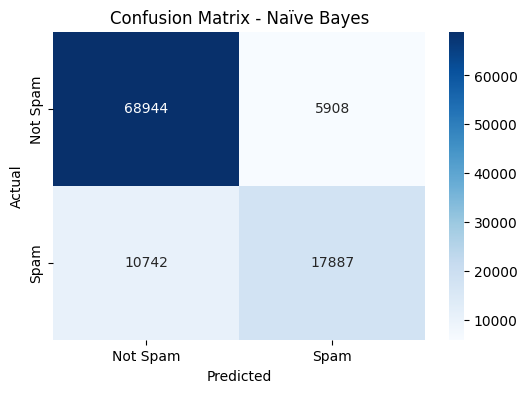

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Naïve Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)  

# Predict on test data
y_pred = nb_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Naïve Bayes Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show()
